In [1]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum

N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.01 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 20
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q


l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_model.step

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [4]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [11]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_gc_localization_matrix(n, radius)
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, model, Q, key, N)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost

In [5]:
inflation = 1.2  # Fixed starting value for inflation
radius_opt = 34.2
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = generate_gc_localization_matrix(n, radius_opt)

states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
# blows up at index 26

In [12]:
key, subkey = random.split(key)
var_cost(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)

NameError: name 'subkey' is not defined

In [14]:
m, C, K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [15]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random


var_cost_grad = grad(var_cost, argnums=0)

inflation = 1.2  # Fixed starting value for inflation
radius_opt = 34.2
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
radii = []
rmses=[]

for i in tqdm(range(10)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_radius = var_cost_grad(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    print(grad_radius)
    radius_opt -= alpha * grad_radius  # Update inflation parameter
    radii.append(radius_opt)
    localization_matrix = generate_gc_localization_matrix(n, radius_opt)

    states, _ = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - m)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(m, states).mean(axis=1).mean()
    crpss.append(crps)
    #clear_output(wait=True)
    
    print(radius_opt, crps)

  0%|          | 0/10 [00:00<?, ?it/s]

nan
nan nan
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
nan
nan nan
nan
nan nan
nan
nan nan
nan
nan nan
nan
nan nan
nan
nan nan
nan
nan nan
nan
nan nan
nan
nan nan


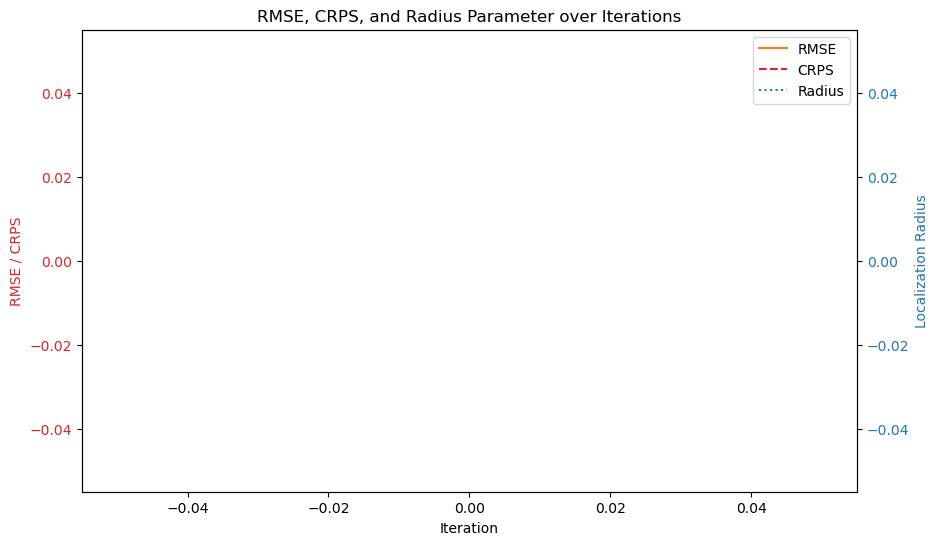

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('RMSE / CRPS', color=color)
ln1 = ax1.plot(rmses, label='RMSE', color='tab:orange', linestyle='-')
ln2 = ax1.plot(crpss, label='CRPS', color='tab:red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Localization Radius', color=color)
ln3 = ax2.plot(radii, label='Radius', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

plt.title('RMSE, CRPS, and Radius Parameter over Iterations')
plt.show()
